## Carregamento e Visão Geral do Dataset

Nesta seção, carregamos o arquivo CSV de imóveis brasileiros, verificamos sua estrutura, os tipos de dados e identificamos a variável alvo (preço) que será utilizada para o modelo de regressão.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregamento do e visualização inicial do dataset
df = pd.read_csv('../data/imoveis-brasil.csv', sep=';')

print(f"Formato do dataset: {df.shape}")
print("\nInformações Iniciais:")
df.info()
print("\nAmostra de dados:")
print(df.head())

Formato do dataset: (12833, 8)

Informações Iniciais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833 entries, 0 to 12832
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     12833 non-null  int64  
 1   property_type  12833 non-null  object 
 2   state          12833 non-null  object 
 3   region         12833 non-null  object 
 4   lat            12833 non-null  float64
 5   lon            12833 non-null  float64
 6   area_m2        11293 non-null  float64
 7   price_brl      12833 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 802.2+ KB

Amostra de dados:
   Unnamed: 0 property_type       state     region       lat        lon  \
0           1     apartment  Pernambuco  Northeast -8.134204 -34.906326   
1           2     apartment  Pernambuco  Northeast -8.126664 -34.903924   
2           3     apartment  Pernambuco  Northeast -8.125550 -34.907601   
3           4  

## Limpeza de Dados e Preparação do Target

Vamos começar a limpeza e preparação. Precisamos descartar a coluna de índice inútil e verificar a distribuição da nossa variável alvo (`price_brl`).

---

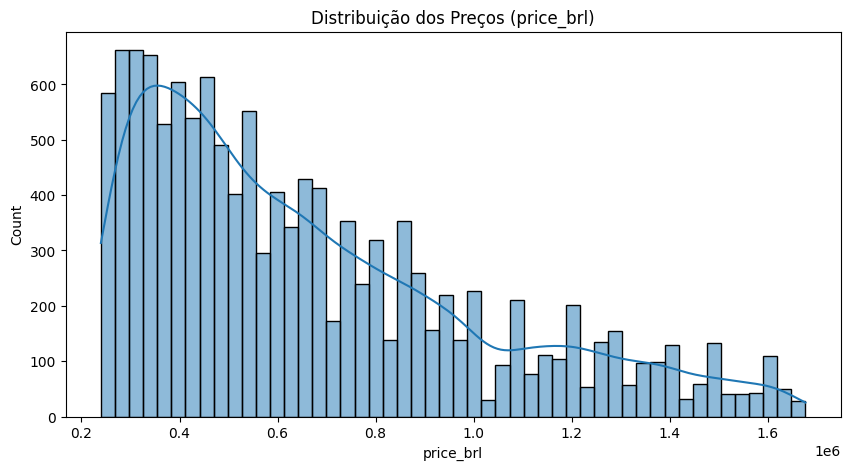

count    1.283300e+04
mean     6.652324e+05
std      3.477194e+05
min      2.395506e+05
25%      3.886942e+05
50%      5.689328e+05
75%      8.504048e+05
max      1.676854e+06
Name: price_brl, dtype: float64


In [3]:
# REmovendo a coluna redundante
df = df.drop(columns=['Unnamed: 0'])

# Visualizando a distribuição da variável alvo
plt.figure(figsize=(10,5))
sns.histplot(df['price_brl'], kde=True, bins=50)
plt.title('Distribuição dos Preços (price_brl)')
plt.show()

print(df['price_brl'].describe())

## Transformação do Target e Imputação da Área

Com base na EDA, identificamos uma forte assimetria à direita (positive skew) na variável alvo (`price_brl`), o que pode prejudicar a performance do modelo de regressão.

**Próximos Passos:**

1.  **Transformação Logarítmica:** Aplicaremos a transformação logarítmica (`np.log1p`) ao `price_brl` para normalizar a distribuição e melhorar a capacidade preditiva do modelo. O modelo fará a previsão no espaço logarítmico, e o resultado será revertido posteriormente (antilog) para o preço em BRL.
2.  **Imputação de Nulos:** A variável `area_m2` possui valores nulos. Como a área é uma *feature* chave para preços, faremos a imputação dos valores faltantes utilizando a **mediana** para minimizar a influência de possíveis *outliers*.

---

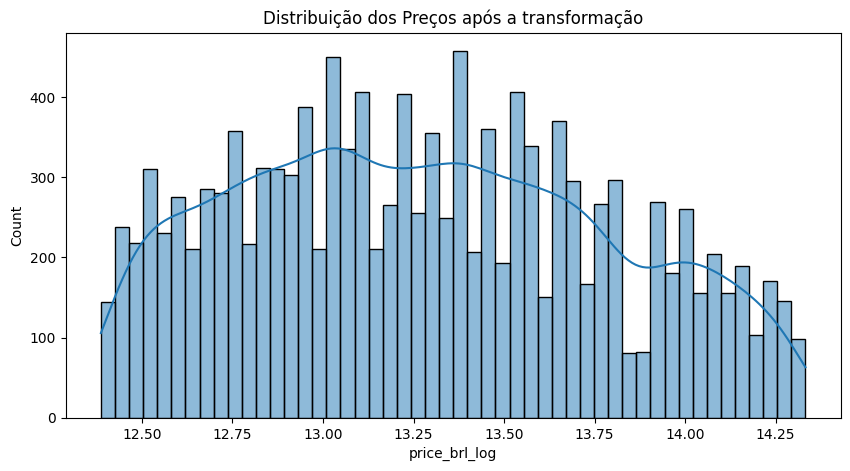

In [4]:
# Transformação da variável alvo
# Apesar do valor zero não ser um problema aqui, vamos aplicar o log1p
df['price_brl_log'] = np.log1p(df['price_brl'])

# Visualização da nova distribuição
plt.figure(figsize=(10,5))
sns.histplot(df['price_brl_log'], kde=True, bins=50)
plt.title('Distribuição dos Preços após a transformação')
plt.show()

In [5]:
# Imputação da mediana na variável area_m2
mediana_area = df['area_m2'].median()
df['area_m2'] = df['area_m2'].fillna(mediana_area)

# Verificação da imputação
print(f"Valores nulos na coluna area_m2: {df['area_m2'].isnull().sum()}")

Valores nulos na coluna area_m2: 0


## Análise de Variáveis Categóricas e Feature Engineering Geográfica

Nesta fase, inspecionamos as variáveis categóricas (`property_type`, `state`, `region`) para determinar a estratégia de codificação mais adequada. O foco é identificar categorias com alta ou baixa cardinalidade.

Também avaliaremos as coordenadas geográficas (`lat`, `lon`) para decidir se as usaremos diretamente ou se criaremos *features* de agrupamento geográfico.

---

In [6]:
# Análise das variáveis categóricas
categorical_cols = df.select_dtypes(include = ['object']).columns

print("Contagem de valores únicos nas Categóricas: ")
for col in categorical_cols:
    print(f"- {col}: {df[col].nunique()} valores únicos.")
    print(df[col].value_counts(normalize = True).head())
    print("-"*30)

Contagem de valores únicos nas Categóricas: 
- property_type: 2 valores únicos.
property_type
apartment    0.783683
house        0.216317
Name: proportion, dtype: float64
------------------------------
- state: 10 valores únicos.
state
Rio de Janeiro       0.233772
Rio Grande do Sul    0.233772
S o Paulo            0.233772
Santa Catarina       0.233772
Pernambuco           0.028988
Name: proportion, dtype: float64
------------------------------
- region: 4 valores únicos.
region
South        0.467545
Southeast    0.467545
Northeast    0.064365
North        0.000545
Name: proportion, dtype: float64
------------------------------


In [7]:
# Verificação da cardinalidade de lat/lon
print(f"Cardinalidade da Latitude: {df['lat'].nunique()}")
print(f"Cardinalidade da Longitude: {df['lon'].nunique()}")

Cardinalidade da Latitude: 6051
Cardinalidade da Longitude: 5919


## Estratégia de Codificação e Divisão de Dados

Com base na análise de cardinalidade, definimos a seguinte estratégia para as variáveis categóricas:

| Variável | Cardinalidade | Estratégia de Codificação | Justificativa |
| :--- | :--- | :--- | :--- |
| **property_type** | 2 | **One-Hot Encoding (OHE)** | Variável binária que distingue Apartamento de Casa. |
| **region** | 4 | **One-Hot Encoding (OHE)** | Baixa cardinalidade (4 regiões), OHE é direto e eficaz. |
| **state** | 10 | **One-Hot Encoding (OHE)** | Cardinalidade moderada (10 estados), essencial para capturar variações regionais de preço. |
| **lat/lon** | Alta | Manter como **Numérica** | Coordenadas geográficas serão mantidas, permitindo que o modelo de árvore encontre *splits* relevantes no espaço geográfico. |

Com todas as variáveis prontas para codificação, separamos o conjunto de dados (`X`) da variável alvo (`y = price_brl_log`). Em seguida, dividimos `X` e `y` em conjuntos de treino e teste para validação do modelo.

---

In [8]:
# Separação dos dados
from sklearn.model_selection import train_test_split

X = df.drop(columns='price_brl_log')
y = df['price_brl_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print(f"Formato do X_train: {X_train.shape}")
print(f"\nFormato do X_test: {X_test.shape}")

Formato do X_train: (10266, 7)

Formato do X_test: (2567, 7)


## Construção do ColumnTransformer (Pré-processamento)

Montamos o ColumnTransformer para aplicar todas as transformações de forma automatizada e segura:
1.  **Categóricas:** One-Hot Encoding (OHE) para 'property_type', 'state', 'region'.
2.  **Numéricas:** Não aplicaremos Scaling, pois usaremos um modelo de árvore (Random Forest), que é robusto a diferentes escalas. No entanto, é importante incluir todas as colunas para o pipeline final.

---

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Definindo os grupos de colunas
ohe_cols = ['property_type', 'state', 'region']
num_cols = ['lat', 'lon', 'area_m2']

# Definindo a pipeline para as numéricas
# Nada será feito, porém vamos criar a pipeline para futuros escalonamentos
num_pipeline = Pipeline([
    ('pass', 'passthrough')
])

# Definindo a pipeline para as categóricas
cat_pipeline = Pipeline([
    ('one_hot_encod', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinando as pipelines no ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, ohe_cols)
    ],
    remainder = 'drop'
)

## Treinamento da Pipeline de Regressão (Random Forest)

Criamos o Pipeline completo combinando o `ColumnTransformer` (pré-processamento) e o modelo de regressão (Random Forest Regressor). O treinamento é feito uma única vez no conjunto `X_train` e `y_train` (log-transformado).

---

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Instanciando o modelo
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Criando e treinando a pipeline completa
full_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', rfr)
])

full_pipeline.fit(X_train, y_train)
print("Treinamento concluído.")

Treinamento concluído.


## Avaliação do Modelo e Reversão da Escala

Agora avaliaremos o modelo no conjunto de teste. Para isso, revertemos as previsões e o target de volta para a escala original (BRL) usando a função exponencial inversa (`np.expm1`).

Usaremos o **R² (coeficiente de determinação)** e o **RMSE (Root Mean Squared Error)** para medir a performance. O RMSE nos dará o erro médio em Reais.


--- Métricas da Performance ---
R² Score (Coeficiente de Determinação): 0.3792
RMSE (Erro médio em BRL): R$276281.49
--------------------


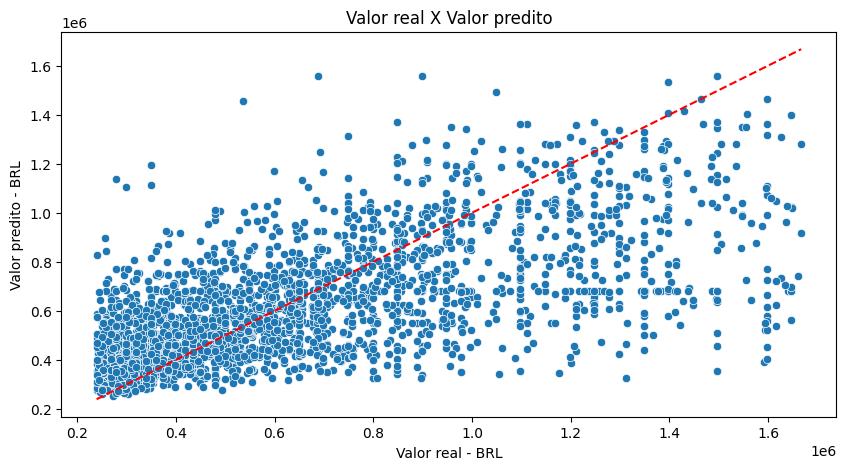

In [11]:
# Fazendo as previsões
y_pred_log = full_pipeline.predict(X_test)

# Revertendo os valores previstos e a variável alvo para o original
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculando as métricas
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print("\n--- Métricas da Performance ---")
print(f"R² Score (Coeficiente de Determinação): {r2:.4f}")
print(f"RMSE (Erro médio em BRL): R${rmse:.2f}")
print("-"*20)

#Plotagem da diferença entre valor real e valor predito
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test_original, y=y_pred)
plt.xlabel("Valor real - BRL")
plt.ylabel("Valor predito - BRL")
plt.title("Valor real X Valor predito")
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         color='red', linestyle='--')
plt.show()

## Otimização de Hiperparâmetros (GridSearchCV)

Devido ao R² Score relativamente baixo (0.3792), usaremos o Grid Search com Validação Cruzada (`Cross-Validation`) para otimizar os hiperparâmetros do Random Forest Regressor e melhorar a performance de previsão.

---

In [12]:
from sklearn.model_selection import GridSearchCV

# Definindo o espaço de busca
params = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [10, 15, 20, None],
    "regressor__min_samples_split": [2,5]
}

# Configurando o GridSearch com a pipeline completa
grid_search = GridSearchCV(
    full_pipeline,
    param_grid = params,
    cv = 3,
    scoring = 'neg_mean_squared_error',
    return_train_score = True,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

print("\nMelhores Parâmetros Encontrados:")
print(grid_search.best_params_)
print(f"\nMelhor Score RMSE (no espaço Log): {-grid_search.best_score_:.4f}")


Melhores Parâmetros Encontrados:
{'regressor__max_depth': 15, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}

Melhor Score RMSE (no espaço Log): 0.0737


## Avaliação do Modelo Otimizado

Utilizamos o melhor estimador encontrado pelo Grid Search e o avaliamos no conjunto de teste para obter as métricas finais (R² e RMSE) na escala original (BRL).

In [13]:
# Extraindo o melhor modelo do GridSearch
best_pipeline = grid_search.best_estimator_

# Fazendo as previsões
y_pred_log_optimized = best_pipeline.predict(X_test)

# REvertendo para a escala real
y_pred_optimized = np.expm1(y_pred_log_optimized)
y_test_original = np.expm1(y_test)

# Calculando as métricas
rmse_optimized = np.sqrt(mean_squared_error(y_test_original, y_pred_optimized))
r2_optimized = r2_score(y_test_original, y_pred_optimized)

print(f"\n--- Métricas de performance otimizadas ---")
print(f"R² Score Otimizado: {r2_optimized:.4f}")
print(f"RMSE (Erro Médio em BRL) Otimizado: R$ {rmse_optimized:.2f}")
print("------------------------------------------")

# Comparação com o modelo não otimizado (do nosso primeiro teste, R$ 276281.49)
previous_rmse = 276281.49
improvement = ((previous_rmse - rmse_optimized) / previous_rmse) * 100
print(f"Melhoria percentual do RMSE: {improvement:.2f}%")


--- Métricas de performance otimizadas ---
R² Score Otimizado: 0.3844
RMSE (Erro Médio em BRL) Otimizado: R$ 275109.06
------------------------------------------
Melhoria percentual do RMSE: 0.42%


## Experimentação: Regressão com XGBoost

Para buscar um R² mais alto, introduziremos o **XGBoost Regressor**, um modelo de Gradient Boosting que geralmente oferece maior poder preditivo em datasets tabulares.

In [14]:
import xgboost as xgb

# Definição do modelo com alguns hiperparametros razoáveis
xgb_reg = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 6,
    random_state = 42,
    n_jobs = -1
)

# Criando a pipeline
xgb_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', xgb_reg)
])

# Treinamento da pipeline
xgb_pipeline.fit(X_train, y_train)

# Avaliação rápida
y_pred_log_xgb = xgb_pipeline.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
y_test_original = np.expm1(y_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb))
r2_xgb = r2_score(y_test_original, y_pred_xgb)

print(f"\n--- Métricas de Performance XGBoost ---")
print(f"R² Score XGBoost: {r2_xgb:.4f}")
print(f"RMSE (Erro Médio em BRL) XGBoost: R$ {rmse_xgb:,.2f}")
print("------------------------------------------")


--- Métricas de Performance XGBoost ---
R² Score XGBoost: 0.3934
RMSE (Erro Médio em BRL) XGBoost: R$ 273,104.21
------------------------------------------


## Otimização do Modelo XGBoost

Aplicaremos o Grid Search com Validação Cruzada (Cross-Validation) focado nos hiperparâmetros-chave do XGBoost (`n_estimators`, `learning_rate`, `max_depth`) para extrair a performance máxima do nosso modelo **XGBoost**.

In [ ]:
# A variável 'preprocessor' e a pipeline básica 'xgb_pipeline' (sem tuning) devem estar disponíveis.

# Criando uma nova pipeline para o Grid Search
xgb_reg_base = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    n_jobs=-1
)
xgb_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', xgb_reg_base)
])

# Definindo o espaço de busca (Grid)
params_xgb = [
    {
        'regressor__n_estimators': [500, 700, 1000],        
        'regressor__learning_rate': [0.03, 0.05, 0.1],     
        'regressor__max_depth': [4, 6, 10]               
    }
]

# Configurando o Grid Search
grid_search_xgb = GridSearchCV(
    xgb_pipeline_base, 
    params_xgb, 
    cv=3,                 
    scoring='neg_mean_squared_error',
    n_jobs=-1             
)

grid_search_xgb.fit(X_train, y_train)

print("\nMelhores Parâmetros Encontrados para XGBoost:")
print(grid_search_xgb.best_params_)


Melhores Parâmetros Encontrados para XGBoost:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 500}

Melhor Score RMSE (no espaço Log) no CV: 0.2663


## Avaliação Final do Modelo XGBoost Otimizado

Utilizaremos o melhor estimador encontrado pelo Grid Search para o XGBoost e realizaremos a avaliação final no conjunto de teste, revertendo a escala para obter o R² e o RMSE na escala original (BRL).

In [18]:
# Extraindo o melhor modelo/pipeline treinado do GridSearch
xgb_pipeline_optimized = grid_search_xgb.best_estimator_

# Fazendo as previsões no conjunto de teste (resultado ainda em log)
y_pred_log_final = xgb_pipeline_optimized.predict(X_test)

# Revertendo as previsões e target de volta para a escala original (BRL)
y_pred_xgb_final = np.expm1(y_pred_log_final)
y_test_original = np.expm1(y_test)

# Encontrando as métricas
rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb_final))
r2_final = r2_score(y_test_original, y_pred_xgb_final)

print(f"\n--- Métricas de Performance XGBoost Otimizado ---")
print(f"R² Score Final: {r2_final:.4f}")
print(f"RMSE (Erro Médio em BRL) Final: R$ {rmse_final:,.2f}")
print("-----------------------------------------------------------")

# Comparação com o modelo antes da otimização
previous_rmse_xgb = 273104.21
improvement_xgb = ((previous_rmse_xgb - rmse_final) / previous_rmse_xgb) * 100
print(f"Melhoria percentual do RMSE em relação ao XGBoost inicial: {improvement_xgb:.2f}%")


--- Métricas de Performance XGBoost Otimizado ---
R² Score Final: 0.4049
RMSE (Erro Médio em BRL) Final: R$ 270,488.74
-----------------------------------------------------------
Melhoria percentual do RMSE em relação ao XGBoost inicial: 0.96%


## Análise da Performance Final

O **XGBoost Regressor Otimizado** entregou o melhor resultado após essas rodadas de treino e *tuning*.

| Métrica | Valor do XGBoost Otimizado |
| :--- | :--- |
| **R² Score** | **0.4049** |
| **RMSE (Erro Médio)** | **R$ 270.488,74** |

O **R² (Coeficiente de Determinação)** de 0.4049 significa que o modelo consegue explicar aproximadamente **40.49% da variância total** nos preços dos imóveis.

**O R² está muito baixo?**

O principal motivo para um R² abaixo de 0.50 é a **limitação das *features*** no *dataset*. No nosso projeto, utilizamos apenas 7 *features* (`lat`, `lon`, `area_m2`, `property_type`, `state`, `region`). O modelo **não tem acesso** a variáveis cruciais que ditam o preço real de um imóvel, tais como:
    * **Número de Quartos/Banheiros/Suítes.**
    * **Ano de Construção ou Idade do Imóvel.**
    * **Características do Condomínio (se for apartamento).**
    * **Proximidade a Escolas/Comércio.**

**Conclusão:** O modelo está fazendo o **melhor trabalho possível** (R² de 0.4049) com as *features* que lhe foram dadas.

---

### Próxima Experimentação: LightGBM

Para garantir a escolha do melhor modelo, introduziremos agora o **LightGBM (Light Gradient Boosting Machine)**.

In [21]:
import lightgbm as lgb

# DEfinindo o modelo LightGBM (usando parâmetros razoáveis de partida)
lgbm_r = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=700,             
    learning_rate=0.04,           
    max_depth=7,
    random_state=42,
    n_jobs=-1,
    verbose = -1
)

# Criando e treinando a Pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgbm_r)
])
lgbm_pipeline.fit(X_train, y_train)


# Avaliação
y_pred_log_lgbm = lgbm_pipeline.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_log_lgbm)
y_test_original = np.expm1(y_test) 

rmse_lgbm = np.sqrt(mean_squared_error(y_test_original, y_pred_lgbm))
r2_lgbm = r2_score(y_test_original, y_pred_lgbm)

print(f"\n--- Métricas de Performance LightGBM ---")
print(f"R² Score LightGBM: {r2_lgbm:.4f}")
print(f"RMSE (Erro Médio em BRL) LightGBM: R$ {rmse_lgbm:,.2f}")


--- Métricas de Performance LightGBM ---
R² Score LightGBM: 0.4073
RMSE (Erro Médio em BRL) LightGBM: R$ 269,958.84


c:\projetos-ds\price-house-predict-mlops\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Otimização do Modelo LightGBM

Aplicaremos o Grid Search com Validação Cruzada (Cross-Validation) focado nos hiperparâmetros-chave do LightGBM para buscar uma performance otimizada.

In [22]:
# Criando uma nova pipeline base para o Grid Search
lgbm_r_base = lgb.LGBMRegressor(
    objective='regression', 
    random_state=42, 
    n_jobs=-1
)

lgbm_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', lgbm_r_base)
])

# Definindo o espaço de busca
param_grid_lgbm = [
    {
        'regressor__n_estimators': [500, 700, 900],        
        'regressor__learning_rate': [0.03, 0.05, 0.1],          
        'regressor__max_depth': [6, 8, 10]                     
    }
]

# Configurando o Grid Search
grid_search_lgbm = GridSearchCV(
    lgbm_pipeline_base, 
    param_grid_lgbm, 
    cv=3,                 
    scoring='neg_mean_squared_error',
    n_jobs=-1             
)

grid_search_lgbm.fit(X_train, y_train)

# Exibindo os melhores parâmetros e o melhor score
print("\nMelhores Parâmetros Encontrados para LightGBM:")
print(grid_search_lgbm.best_params_)


Melhores Parâmetros Encontrados para LightGBM:
{'regressor__learning_rate': 0.03, 'regressor__max_depth': 8, 'regressor__n_estimators': 900}


## Avaliação Final do Modelo LightGBM Otimizado

Utilizaremos o melhor estimador encontrado pelo Grid Search para o LightGBM e realizamos a avaliação final no conjunto de teste.

In [23]:
# Extraindo o melhor modelo/pipeline treinado do GridSearch
best_lgbm_pipeline = grid_search_lgbm.best_estimator_

# Fazendo as previsões no conjunto de teste (resultado ainda em log)
y_pred_log_final_lgbm = best_lgbm_pipeline.predict(X_test)

# Revertendo previsões e target de volta para a escala original (BRL)
y_pred_final_lgbm = np.expm1(y_pred_log_final_lgbm)
y_test_original = np.expm1(y_test)

# Cálculo das métricas
rmse_final_lgbm = np.sqrt(mean_squared_error(y_test_original, y_pred_final_lgbm))
r2_final_lgbm = r2_score(y_test_original, y_pred_final_lgbm)

print(f"\n--- Métricas de Performance FINAL (LightGBM Otimizado) ---")
print(f"R² Score Final: {r2_final_lgbm:.4f}")
print(f"RMSE (Erro Médio em BRL) Final: R$ {rmse_final_lgbm:,.2f}")
print("-----------------------------------------------------------")

# Comparação com o XGBoost Otimizado (R²: 0.4049, RMSE: R$ 270488.74)
previous_rmse_xgb_opt = 270488.74
improvement_lgbm_vs_xgb = ((previous_rmse_xgb_opt - rmse_final_lgbm) / previous_rmse_xgb_opt) * 100
print(f"Melhoria percentual do RMSE em relação ao XGBoost Otimizado: {improvement_lgbm_vs_xgb:.2f}%")


--- Métricas de Performance FINAL (LightGBM Otimizado) ---
R² Score Final: 0.4084
RMSE (Erro Médio em BRL) Final: R$ 269,698.03
-----------------------------------------------------------
Melhoria percentual do RMSE em relação ao XGBoost Otimizado: 0.29%


c:\projetos-ds\price-house-predict-mlops\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Análise da Performance Final do Modelo LightGBM Otimizado

Este modelo representa o melhor desempenho encontrado até agora e será o benchmark (R² de 0.4084) que o próximo modelo precisa superar.

| Métrica | XGBoost Otimizado | **LightGBM Otimizado (LÍDER)** | Diferença |
| :--- | :--- | :--- | :--- |
| **R² Score** | 0.4049 | **0.4084** | $\approx 0.35\%$ Melhor |
| **RMSE (Erro em BRL)** | R$ 270.488,74 | **R$ 269.698,03** | **R$ 790,71** Melhor |

## Experimentação: Regressão com CatBoost

Faremos agora um último teste de Gradient Boosting, dessa vez com o **CatBoostRegressor**. Avaliaremos seu desempenho comparado ao benchmark estabelecido pelo **LightGBM Otimizado**.

In [24]:
import catboost as cb

# Definindo o modelo CatBoost
cbr = cb.CatBoostRegressor(
    loss_function='RMSE', 
    iterations=500,       
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=0,            
    thread_count=-1
)

# Criando a Pipeline
cbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', cbr)
])

# Treinando o Pipeline
cbr_pipeline.fit(X_train, y_train)

y_pred_log_cbr = cbr_pipeline.predict(X_test)
y_pred_cbr = np.expm1(y_pred_log_cbr)
y_test_original = np.expm1(y_test) 

rmse_cbr = np.sqrt(mean_squared_error(y_test_original, y_pred_cbr))
r2_cbr = r2_score(y_test_original, y_pred_cbr)

print(f"\n--- Métricas de Performance CatBoost ---")
print(f"R² Score CatBoost: {r2_cbr:.4f}")
print(f"RMSE (Erro Médio em BRL) CatBoost: R$ {rmse_cbr:,.2f}")


--- Métricas de Performance CatBoost ---
R² Score CatBoost: 0.3786
RMSE (Erro Médio em BRL) CatBoost: R$ 276,411.15


## Otimização do CatBoost Regressor

O CatBoost teve um desempenho inicial inferior ao LightGBM, mas vamos realizar o ajuste de hiperparâmetros para ver se conseguimos extrair o máximo de precisão dele.

Aplicaremos o Grid Search com Validação Cruzada no CatBoost para tentar reverter a performance inicial baixa e extrair o máximo de precisão do modelo, desafiando o LightGBM Otimizado.

In [25]:
# Criando uma nova pipeline base para o Grid Search
cbr_r_base = cb.CatBoostRegressor(
    loss_function='RMSE', 
    random_state=42, 
    verbose=0,
    thread_count=-1 
)

cbr_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', cbr_r_base)
])

# Definindo o espaço de busca
param_grid_cbr = [
    {
        'regressor__iterations': [500, 700, 900],        
        'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'regressor__depth': [4, 6, 8, 10]                  
    }
]

# Configurar o Grid Search
grid_search_cbr = GridSearchCV(
    cbr_pipeline_base, 
    param_grid_cbr, 
    cv=3,                 
    scoring='neg_mean_squared_error',
    n_jobs=-1             
)

grid_search_cbr.fit(X_train, y_train)

# Exibir os melhores parâmetros e o melhor score
print("\nMelhores Parâmetros Encontrados para CatBoost:")
print(grid_search_cbr.best_params_)


Melhores Parâmetros Encontrados para CatBoost:
{'regressor__depth': 10, 'regressor__iterations': 900, 'regressor__learning_rate': 0.05}


## Avaliação Final do Modelo CatBoost Otimizado

Realizaremos a avaliação final do CatBoost otimizado. Se ele não superar o benchmark estabelecido, o LightGBM Otimizado será o modelo escolhido.

In [28]:
# Extraindo o melhor modelo/pipeline treinado do GridSearch
best_cbr_pipeline = grid_search_cbr.best_estimator_

# Fazendo previsões no conjunto de teste (resultado em log)
y_pred_log_final_cbr = best_cbr_pipeline.predict(X_test)

# Revertendo previsões e target de volta para a escala original (BRL)
y_pred_final_cbr = np.expm1(y_pred_log_final_cbr)
y_test_original = np.expm1(y_test)

# Cálculo das métricas
rmse_final_cbr = np.sqrt(mean_squared_error(y_test_original, y_pred_final_cbr))
r2_final_cbr = r2_score(y_test_original, y_pred_final_cbr)

print(f"\n--- Métricas de Performance (CatBoost Otimizado) ---")
print(f"R² Score Final: {r2_final_cbr:.4f}")
print(f"RMSE (Erro Médio em BRL) Final: R$ {rmse_final_cbr:,.2f}")
print("-----------------------------------------------------------")

# Comparação com o LightGBM Otimizado (Líder: R²: 0.4084, RMSE: R$ 269698.03)
previous_rmse_lgbm_opt = 269698.03
improvement_cbr_vs_lgbm = ((previous_rmse_lgbm_opt - rmse_final_cbr) / previous_rmse_lgbm_opt) * 100
print(f"Melhoria percentual do RMSE em relação ao LightGBM Otimizado: {improvement_cbr_vs_lgbm:.2f}%")


--- Métricas de Performance (CatBoost Otimizado) ---
R² Score Final: 0.4096
RMSE (Erro Médio em BRL) Final: R$ 269,417.42
-----------------------------------------------------------
Melhoria percentual do RMSE em relação ao LightGBM Otimizado: 0.10%


### Tabela de Comparação de Performance

| Modelo | R² Score | RMSE (Erro em BRL) |
| :--- | :--- | :--- |
| Random Forest Otimizado | 0.3844 | R$ 275.109,06 |
| XGBoost Otimizado | 0.4049 | R$ 270.488,74 |
| LightGBM Otimizado | 0.4084 | R$ 269.698,03 |
| **CatBoost Otimizado** | **0.4096** | **R$ 269.417,42** |


---

## Serialização do Modelo Selecionado (CatBoost Otimizado)

Após extensos testes e otimização, o **CatBoost Regressor Otimizado** (R² 0.4096) foi o modelo selecionado. O Pipeline completo será serializado em formato `.pkl` e armazenado na pasta da API, pronto para ser carregado para inferência em produção.

In [29]:
import joblib
import os

# O melhor modelo é o best_cbr_pipeline
final_pipeline = best_cbr_pipeline

save_dir = '../../api/models/'
save_path = os.path.join(save_dir, 'house_price_pipeline.pkl')

# Cria o diretório se não existir
os.makedirs(save_dir, exist_ok=True)

joblib.dump(final_pipeline, save_path)

print(f"Pipeline (CatBoost Otimizado) salva com sucesso em: {save_path}")

Pipeline (CatBoost Otimizado) salva com sucesso em: ../../api/models/house_price_pipeline.pkl
